**Detect Puncta**

Aim : Unbiasedly detect puncta within cells, to quantify the number, size and intensity

If 'puncta' are present, there must be a connected region or region(s) bigger than a single pixel, 
in which all pixels are above the average in that cell.

In [1]:
import pandas as pd
import numpy as np
import skimage.io as io
io.use_plugin('tifffile')

#Load image
im = io.imread('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1.tif')

#Slice1 contains ~58 nuclei, 52 not touching the border

#Select Hoechst stack
Hoechst_stack = im[:,:,:,0]

#Select GFP stack
GFP_stack = im[:,:,:,1]


In [2]:
z=4

z_size, x_size, y_size = Hoechst_stack.shape

z_scale = 0.26 # µm per plane for 100x NIC confocal images
xy_scale = 0.065 # µm per pixel for 100x NIC confocal images

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
GFP_stack.shape

(24L, 2048L, 2048L)

In [5]:
GFP_stack_minimum = (GFP_stack).min()
GFP_stack_max = (GFP_stack).max()

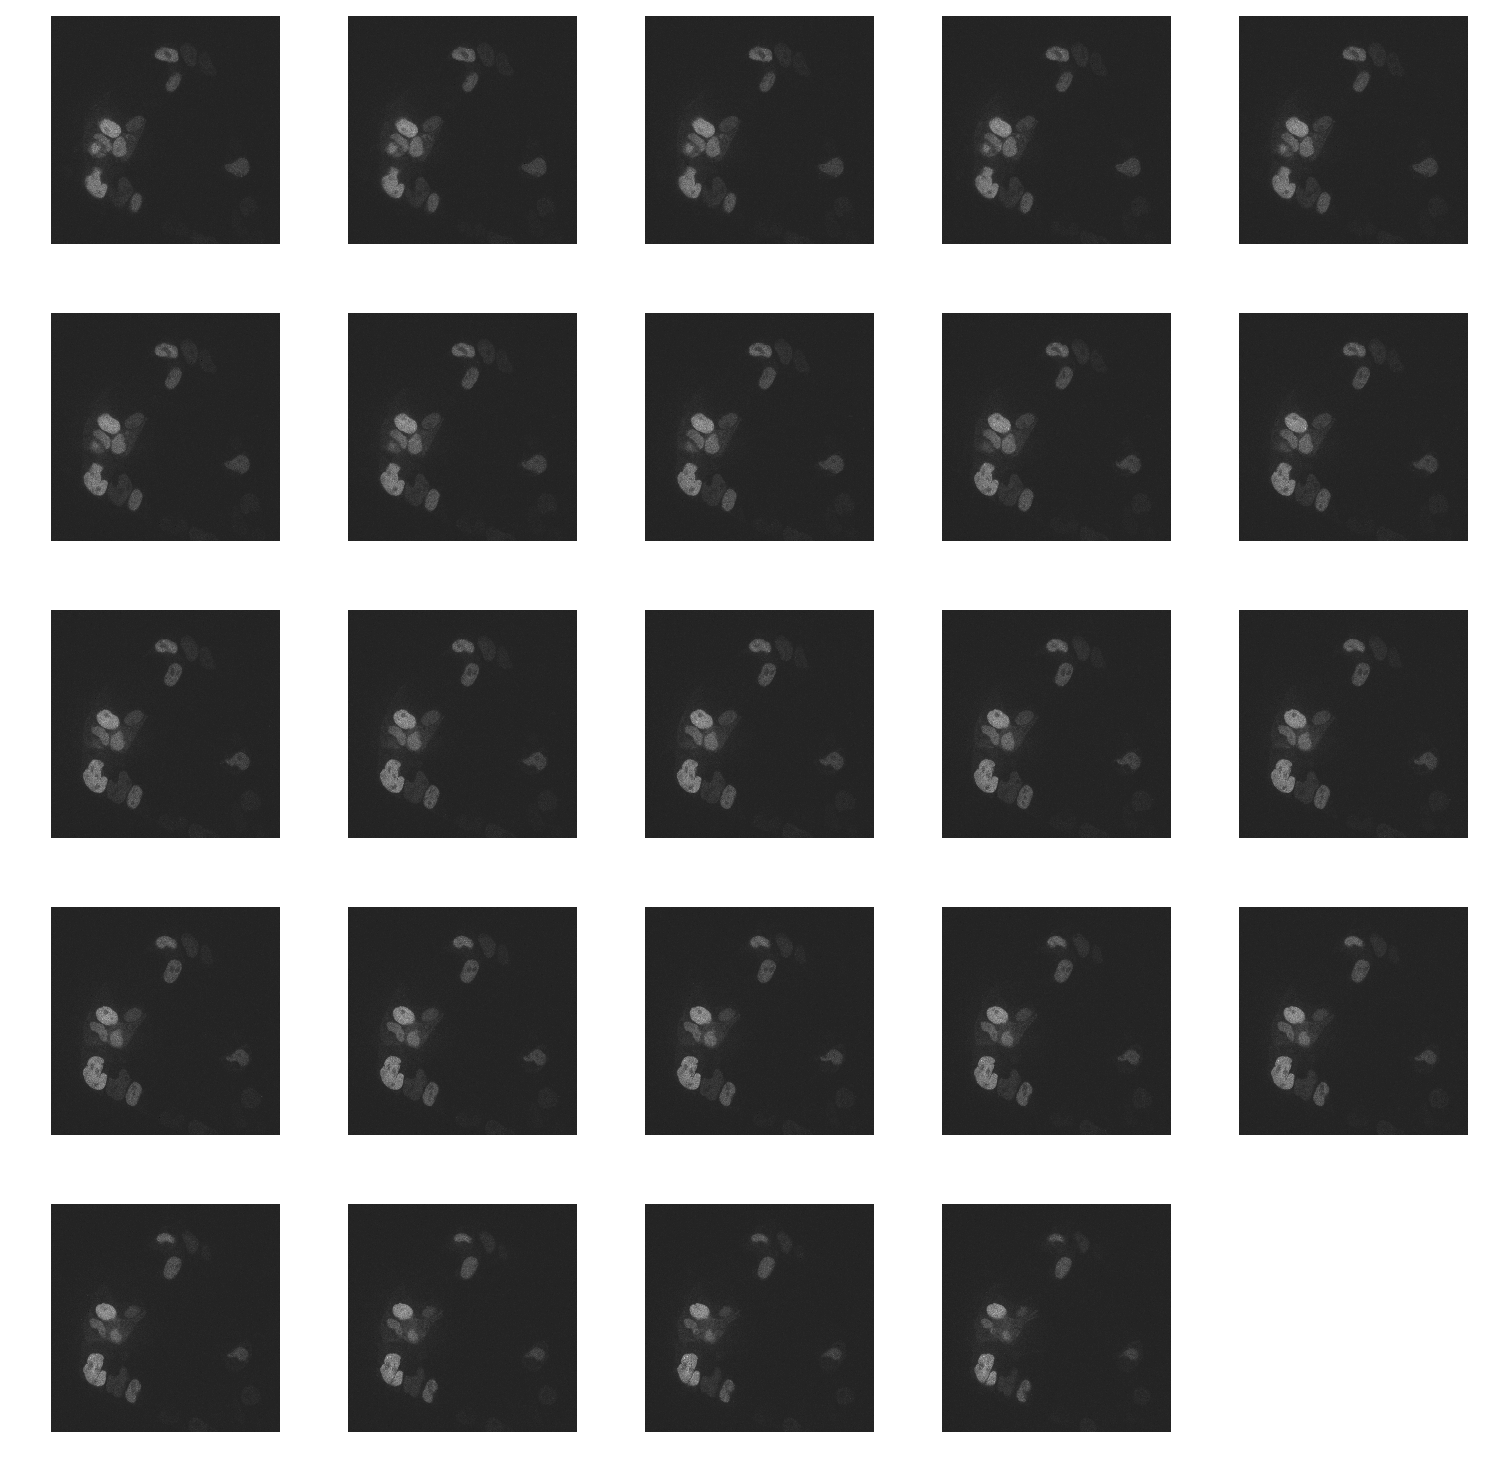

In [6]:
##Lets look at the GFP channel
nrows = np.int(np.ceil(np.sqrt(z_size)))
ncols = np.int(z_size // nrows + 1)

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
for n in range(z_size):
    i = n // ncols
    j = n % ncols
    axes[i, j].imshow(GFP_stack[n],
                      interpolation='nearest',
                      vmin = GFP_stack_minimum,                 #constant minimum display value
                      vmax = GFP_stack_max,                     #constant maximum display value
                      cmap='gray')
    
    axes[i, j].axis("off")
    
## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
        fig.delaxes(ax)
fig.tight_layout()

In [7]:
##How can we detect puncta in this stack?


In [ ]:
##Pixels above mean+std


In [ ]:
from scipy import ndimage

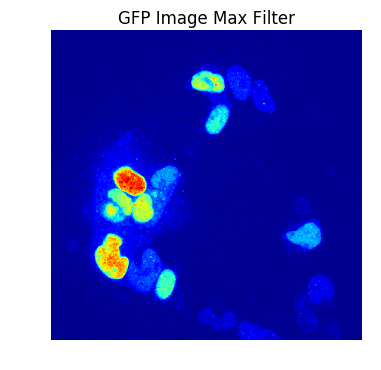

In [12]:
#Measure maxima intensities and count (bear in mind that we need to cluster to prevent over estimates)
#Max filter makes local maxima more obvious.
image_max=ndimage.maximum_filter(GFP_stack,footprint=np.ones((3,10,10)))
plt.imshow(image_max[z],
           #vmin = GFP_stack_minimum, 
           #vmax = GFP_stack_max
          )
plt.axis("off")
plt.title("GFP Image Max Filter")

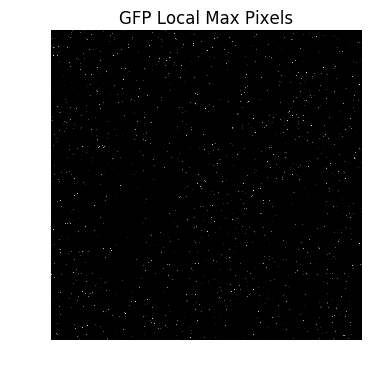

In [13]:
#Detect local maxima (intensity agnostic) #I don't think this is the most sensible approach

#local_max = ndimage.maximum_filter(GFP_stack, size=2.5)==GFP_stack

#local_max is a binary array
local_max = image_max==GFP_stack
plt.imshow(local_max[z], cmap="gray") #individual voxels are too small to see these are your markers
plt.axis("off")
plt.title("GFP Local Max Pixels")

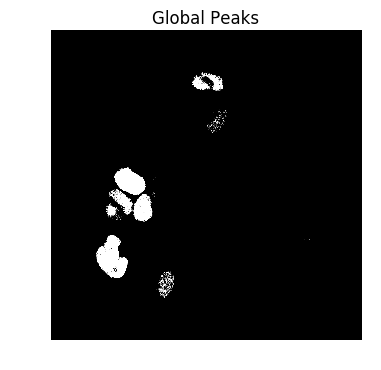

In [14]:
##Detect Global Peaks (Size agnostic)
pT=225 #How to choose threshold?
puncta=GFP_stack>pT
plt.imshow(puncta[z], cmap="gray")
plt.axis("off")
plt.title("Global Peaks")

In [ ]:
##Coordinates of local maxima within the nucleus. Later replaced by coodrinates of local nuclear maxima > 4000.
header=(['z','r','c'])
coords=np.transpose(puncta.nonzero())
coords = pd.DataFrame(coords, columns=header)
coords

In [24]:
##
coords["pixel_GFP"] = GFP_stack[coords["z"],coords["r"],coords["c"]]

In [25]:
coords

,z,r,c,pixel_GFP
0,0,934,502,264
1,0,934,503,256
2,0,934,504,260
3,0,934,505,247
4,0,934,506,241
5,0,934,507,242
6,0,934,508,290
7,0,934,509,278
8,0,934,510,309
9,0,934,511,289


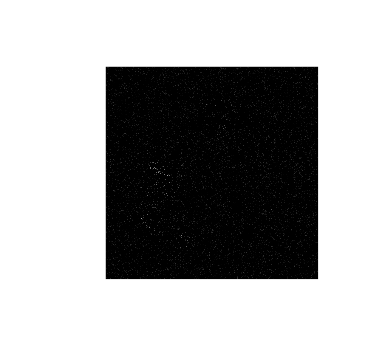

In [36]:
from scipy import ndimage

size=5
peak_threshold=5000

#Find puncta
image_max = ndimage.maximum_filter(im[z,:,:,1], size=size, mode='constant')
puncta = (im[z,:,:,1] == image_max) #What is happening here
im[:,:,:,1] *= puncta

# Find peaks
image_t = (im[z,:,:,1] > peak_threshold) * 1

# get coordinates of peaks
f = np.transpose(image_t.nonzero())

# Show
img = plt.imshow(np.asarray(im[z,:,:,1]), cmap='gray')
plt.plot(f[:, 1], f[:, 0], 'o', markeredgewidth=1, markeredgecolor='g', markerfacecolor='None')

plt.axis('off')
plt.savefig('local_max.png', format='png', bbox_inches='tight')
plt.show()   

In [47]:
##Label puncta
import mahotas as mh

labeled_peaks, n_puncta = mh.label(puncta)

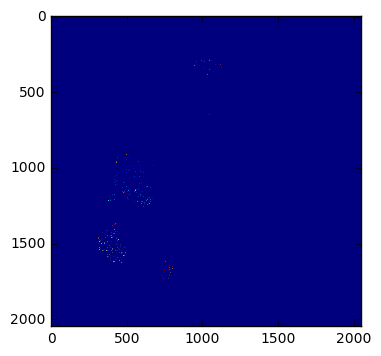

In [49]:
plt.imshow(labeled_peaks[z])
plt.axis('off')
plt.title("GFP Local Max")

In [15]:
#[3] Try local threshold
#Must be a 2D array
from skimage.filters import threshold_otsu, threshold_adaptive
import numpy as np

GFP_mask3=np.zeros_like(GFP_stack)
block_size = 35 #Width of neighbourhood in pixels. Default was 35
offset = -10    #Constant subtracted from mean. Default was 10

for z, frame in enumerate(GFP_stack):
    GFP_mask3[z] = threshold_adaptive(frame, block_size, 'mean', offset)

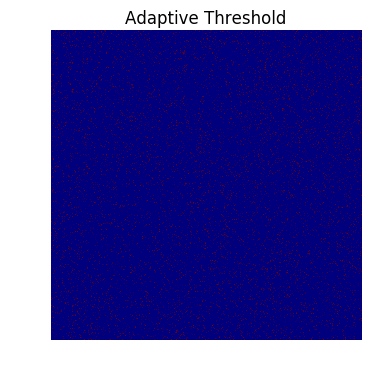

In [61]:
plt.imshow(GFP_mask3.max(axis=0))
plt.axis('off')
plt.title('Adaptive Threshold')